In [13]:
import feather

from math import log

import numpy as np
import pandas as pd

from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
path = '../data/processed/EDY/holdings_summary_s_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(18383, 10)

In [75]:
### Load the data files

path = '../data/processed/EDY/holdings_s_s.npz'
holdings = sparse.load_npz(path)

path = '../data/processed/EDY/holdings_b.npz'
holdings_b = sparse.load_npz(path)

print(holdings.shape)
print(holdings_b.shape)

(18383, 722)
(35791, 722)


In [76]:
holdings = holdings
holdings_b = holdings_b

In [77]:
port_number = holdings.shape[0]
port_number

18383

## Analysis

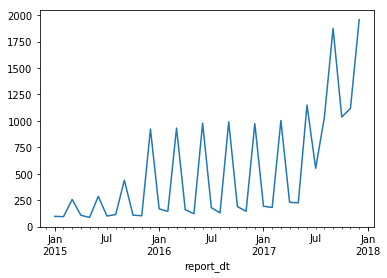

In [78]:
summary.groupby('report_dt')['index'].count().plot()

# Average Portfolio per report_dt

In [137]:
holdings_d = pd.DataFrame(holdings.toarray())
holdings_d = holdings_d.astype(int)

In [120]:
holdings_d = holdings_d.groupby(summary['report_dt']).rolling(2).mean()

In [138]:
holdings_d['report_dt'] = summary['report_dt']

In [139]:
holdings_d = holdings_d.set_index('report_dt')

In [142]:
holdings_d = holdings_d.resample('Q', label='right', closed='right').mean()

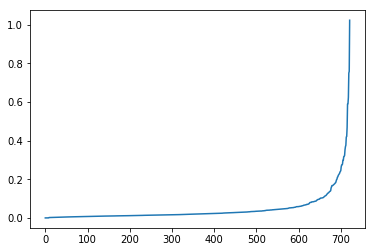

In [154]:
plt.plot(holdings_d.mean().sort_values().values)


# Old IDF TF calc

### Round to int

In [18]:
holdings.data = holdings.data.round().astype(int)

## Calc IDF

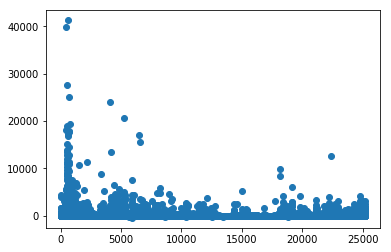

In [7]:
col_sum = holdings[:,:].sum(0).T
plt.plot(col_sum, 'o')

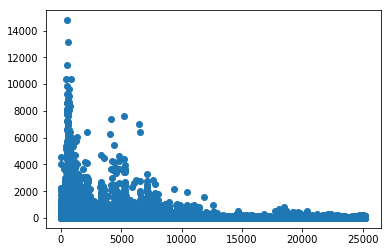

In [8]:
col_sum_b = holdings_b.sum(0).T
plt.plot(col_sum_b,'o')

In [9]:
def IDF_calc(x,port_number):
    return 1 + log(port_number / (x))
IDF_calc = np.vectorize(IDF_calc)

IDFs = IDF_calc(col_sum_b,port_number)

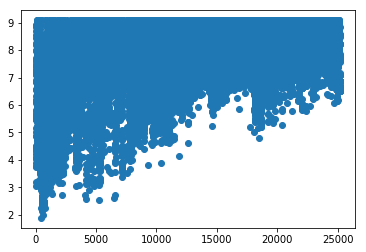

In [10]:
plt.plot(IDFs,'o')

## Multiply IDF with TF

In [11]:
IDFs_matrix = np.tile(IDFs.T,(port_number,1))

In [12]:
IDFs_matrix.shape

(35791, 25221)

In [13]:
holdings.shape

(35791, 25221)

In [14]:
holdings_transformed = holdings.multiply(IDFs_matrix).tocsr()

In [15]:
holdings_transformed

<35791x25221 sparse matrix of type '<class 'numpy.float64'>'
	with 3676753 stored elements in Compressed Sparse Row format>

## PCA

In [16]:
from sklearn.decomposition import TruncatedSVD

In [17]:
X = holdings_transformed.T
svd = TruncatedSVD(n_components=100)
svd.fit(X)  

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

In [18]:
holdings_transformed = svd.components_

In [19]:
print(svd.explained_variance_ratio_)  
print()
print(svd.explained_variance_ratio_.sum())  


[0.03284013 0.02940519 0.0217196  0.01822947 0.01619844 0.01598885
 0.01595347 0.01588177 0.01372447 0.01260136 0.01150492 0.01132596
 0.01127927 0.01017385 0.01010733 0.00943043 0.00868306 0.00810998
 0.00805503 0.00791022 0.00787856 0.00777063 0.00752409 0.00750976
 0.0072122  0.00686903 0.00684922 0.00619134 0.00607072 0.00605877
 0.00602982 0.00601419 0.00590364 0.00581736 0.00578647 0.00562018
 0.00530631 0.00523002 0.00520698 0.00509268 0.00481865 0.00480385
 0.00480902 0.00473937 0.00466354 0.00466467 0.00461709 0.00461853
 0.00459496 0.00452169 0.00408228 0.0039742  0.0039642  0.00391013
 0.0038781  0.00382318 0.00381299 0.00376564 0.00366841 0.00361
 0.00358005 0.00352456 0.00348014 0.00343553 0.00339929 0.00339188
 0.00335098 0.00333636 0.00331655 0.00329428 0.00324219 0.00314433
 0.00310144 0.00300628 0.00298817 0.0028571  0.0027187  0.00268966
 0.00267429 0.00260721 0.00255844 0.00252045 0.00251322 0.00247533
 0.00246549 0.00244619 0.00238083 0.00236792 0.00234248 0.0023324

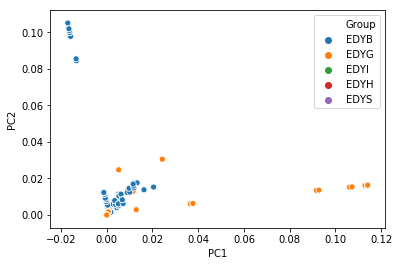

In [20]:
result_mat = pd.DataFrame({'PC1': svd.components_[1], 'PC2':svd.components_[0], 'Group': summary['crsp_obj_cd']})

sns.scatterplot('PC1','PC2', hue='Group', data = result_mat)

In [26]:
holdings_transformed = pd.DataFrame(holdings_transformed).T

## Save

In [27]:
### Load the data files
path = '../data/processed/EDY/holdings_s_lsa.npz'
feather.write_dataframe(holdings_transformed,path)